In [1]:
###################################################################################################
##### super resolution of whole slide images with conditional generative adversarial networks #####
###################################################################################################
#### SCL+GAN
import os, shutil, glob, warnings
import argparse
import sys
from datetime import datetime

import matplotlib.pyplot as plt
from torchvision import transforms, utils
import torchvision
from skimage import exposure, color, io, img_as_float, img_as_ubyte
from skimage.util import view_as_windows, pad, montage
# from scipy.stats import signaltonoise
from PIL import Image, ImageFilter

from math import log10, log, exp, e, log2
import pandas as pd
import numpy as np
from torch.utils.tensorboard import SummaryWriter
from collections import OrderedDict

import torch.nn.functional as F
import torch.nn as nn
import torch.optim as optim
import torch
from torch.utils.data import DataLoader
from torch.autograd import Variable
import torch.optim.lr_scheduler as lr_scheduler

import data
import srmodels as models

In [2]:
os.environ['CUDA_VISIBLE_DEVICES'] = '4'

In [3]:
def data_loader(args, csv='train'):
    if csv=='train':
        transformed_dataset = data.Pair_Dataset(csv_file=data.compress_csv_path(csv),
                                                   transform=data.Compose([
#                                                        data.RandomCrop((args.patch_size, args.patch_size)),
                                                       data.Recale(args.patch_size),
#                                                        data.Flip(),
#                                                        data.Rotate(),
                                                       data.ToTensor()
                                               ]))
        dataloader = DataLoader(transformed_dataset, batch_size=args.batch_size, shuffle=True, num_workers=args.num_workers)
    if csv=='valid':
        transformed_dataset = data.Pair_Dataset(csv_file=data.compress_csv_path(csv),
                                                   transform=data.Compose([
#                                                        data.Crop((args.patch_size, args.patch_size)),
                                                       data.Recale(args.patch_size),
                                                       data.ToTensor()
                                               ]))
        dataloader = DataLoader(transformed_dataset, batch_size=args.batch_size, shuffle=False, num_workers=args.num_workers)
    return dataloader

In [4]:
def train(args, epoch, run, l, dataloader, gan=True):
    epoch_loss = 0
    gan_loss = 0
    total_loss = 0
    dis_loss = 0
    generator.train()
    for iteration, batch in enumerate(dataloader):
        real_mid = Variable(batch['input'].type(Tensor).to(device), requires_grad=False)
        real_high = Variable(batch['output'].type(Tensor).to(device), requires_grad=False)
        
        # Adversarial ground truths
        valid = Variable(Tensor(np.ones((real_mid.size(0), *patch))).to(device), requires_grad=False)
        fake = Variable(Tensor(np.zeros((real_mid.size(0), *patch))).to(device), requires_grad=False)
        
        #---------------
        #  Train Generator
        #---------------   
        
        optimizer_G.zero_grad()
        
        # GAN loss
        fake_high = generator(real_mid)
        if gan:
            pred_fake = discriminator(fake_high, real_mid)
            loss_GAN = criterionMSE(pred_fake, valid)
        
        # Identity
        lossL1 = criterionL(fake_high, real_high)               
        loss_pixel = lossL1
        
        # Total loss
        if gan:
            loss_G = l * loss_GAN + (1-l) * loss_pixel   
            loss_G.backward()
            total_loss = total_loss + loss_G.item()
            gan_loss = gan_loss + loss_GAN.item()
        else:
            loss_pixel.backward()
        optimizer_G.step()
        
        #---------------
        #  Train Discriminator
        #---------------  
        
        if gan and iteration % args.num_critic == 0:
            optimizer_D.zero_grad() 
            # Real loss
            pred_real = discriminator(real_high, real_mid)
            loss_real = criterionMSE(pred_real, valid)
        
            # Fake loss
            pred_fake = discriminator(fake_high.detach(), real_mid)
            loss_fake = criterionMSE(pred_fake, fake)

            # Total loss
            loss_D = 0.5 * (loss_real + loss_fake)
            loss_D.backward()
            optimizer_D.step()
            dis_loss = dis_loss + loss_D.item()
        
        epoch_loss = epoch_loss + loss_pixel.item()
        
        if gan:
            sys.stdout.write('\r[%d/%d][%d/%d] Discriminator_Loss: %.4f Generator_Loss (Identity/Advers/Total): %.4f/%.4f/%.4f' 
                             % (epoch, args.num_epochs, iteration, len(dataloader), loss_D.item(), 
                                loss_pixel.item(), loss_GAN.item(), loss_G.item()))
        else:
            sys.stdout.write('\r[%d/%d][%d/%d] Generator_L1_Loss: %.4f' 
                             % (epoch, args.num_epochs, iteration, len(dataloader), loss_pixel.item()))
    print("\n ===> Epoch {} Complete: Avg. Loss: {:.4f}".format(epoch, epoch_loss / len(dataloader)))
    
    g_path = os.path.join('weights', run, 'generator.pth')
    d_path = os.path.join('weights', run, 'discriminator.pth')
    os.makedirs(os.path.join('weights', run), exist_ok=True)
    torch.save(generator.state_dict(), g_path)
    if gan:
        os.makedirs(os.path.join('weights', run), exist_ok=True)
        torch.save(discriminator.state_dict(), d_path)

In [5]:
def print_output(trained_model, dataloader_valid):
    generator.eval()
    os.makedirs('print-sr-nogan', exist_ok=True)
    with torch.no_grad():      
        print("===> 8x:")
        for iteration, batch in enumerate(dataloader_valid):     
            input, target = batch['input'].to(device), batch['output'].to(device)
            imgs_input = Variable(input.type(Tensor))
            prediction = trained_model(imgs_input)
            target = target.float()    
            imgs_input = imgs_input[:, :, :, :]
            prediction = prediction[:, :, :, :]
            target = target[:, :, :, :]
            plt.figure(figsize=(20, 6))
            grid = utils.make_grid(imgs_input).cpu()
            utils.save_image(grid, 'print-sr-nogan/input.tif')
            input_downsampled = grid.numpy().transpose((1, 2, 0))
            plt.imshow(input_downsampled, interpolation='bicubic')
            plt.axis('off') 
            plt.figure(figsize=(20, 6))
            grid = utils.make_grid(prediction).cpu()
            utils.save_image(grid, 'print-sr-nogan/output.tif')
            prediction = np.clip(grid.numpy().transpose((1, 2, 0)), 0, 1)
            plt.imshow(prediction, interpolation='bicubic')
            plt.axis('off')    
            plt.figure(figsize=(20, 6))
            grid = utils.make_grid(target).cpu()
            utils.save_image(grid, 'print-sr-nogan/target.tif')
            target = grid.numpy().transpose((1, 2, 0))
            plt.imshow(target, interpolation='bicubic')
            plt.axis('off')                                  
            break        

In [6]:
def p_snr(path_input, path_ref):
    MSE = nn.MSELoss()
    imgs_input = glob.glob(os.path.join(path_input, '*.tiff'))
    imgs_ref = glob.glob(os.path.join(path_ref, '*.tiff'))
    ave_psnr = 0
    for i in range(len(imgs_input)):
        img_input = torch.from_numpy(img_as_float(io.imread(imgs_input[i]).transpose(2, 1, 0)))               
        img_ref = torch.from_numpy(img_as_float(io.imread(imgs_ref[i]).transpose(2, 1, 0)))
        img_input = img_input[None, :]
        img_ref = img_ref[None, :]             
        mse = MSE(img_input, img_ref)               
        psnr = 10 * log10(1 / mse.item())
        ave_psnr += psnr
    ave_psnr = ave_psnr / len(imgs_input)
    return ave_psnr

In [7]:
def test(args, generator, dataloader, criterion):
    with torch.no_grad():
        epoch_loss = 0
        generator.eval()
        for iteration, batch in enumerate(dataloader):
            real_mid = Variable(batch['input'].type(Tensor).to(device), requires_grad=False)
            real_high = Variable(batch['output'].type(Tensor).to(device), requires_grad=False)
            fake_high = generator(real_mid)
            epoch_loss = epoch_loss + criterion(fake_high, real_high).item()
        return epoch_loss / len(dataloader)

In [8]:
args = argparse.Namespace()
args.img_channel = 1
args.batch_size = 16
args.patch_size = 512
args.up_scale = 5
args.num_workers = 0
args.num_epochs = 100
args.g_lr = 0.0001
args.d_lr = 0.00001
args.dataset = 'TMA'
args.num_critic = 10
args.normalize = None
args.percep_weight = 0.03
args.run_from = None
args.start_epoch = 1
args.gan = True

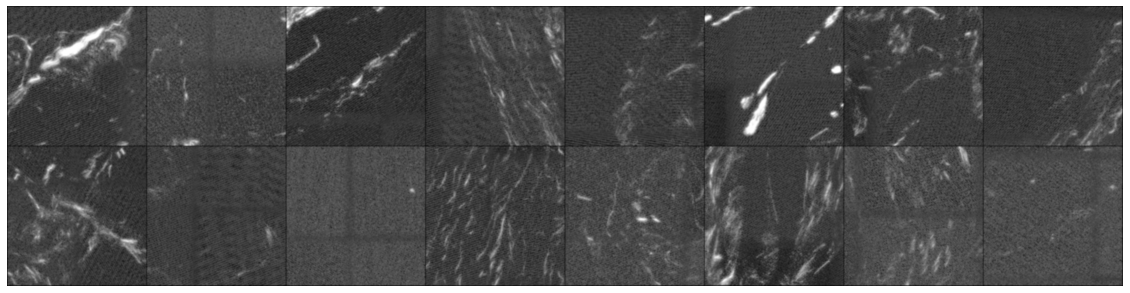

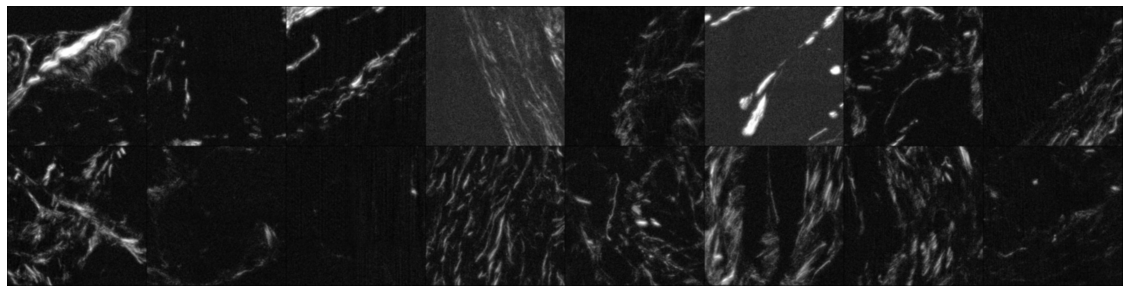

In [9]:
device = torch.device('cuda:0')
data.generate_compress_csv()
valid_dataset = data_loader(args, 'valid')
data.show_patch(valid_dataset, 0)
# define model
generator = models.Generator(args.img_channel, base_channel=16, norm='instance')
# generator = models.Net(args.img_channel, upscale_factor=2)
generator.to(device);
discriminator = models.Discriminator(args.img_channel, norm='batch')
discriminator.to(device);
criterionL = nn.L1Loss().cuda()
criterionMSE = nn.MSELoss().cuda()
optimizer_G = torch.optim.Adam(generator.parameters(), lr=args.g_lr)
optimizer_D = torch.optim.Adam(discriminator.parameters(), lr=args.d_lr)
patch = (1, args.patch_size // 2 ** 4, args.patch_size // 2 ** 4)
Tensor = torch.cuda.FloatTensor

In [11]:
if args.run_from is not None:
    generator.load_state_dict(torch.load(os.path.join('weights', args.run_from, 'generator.pth')))
    try:
        discriminator.load_state_dict(torch.load(os.path.join('weights', args.run_from, 'discriminator.pth')))
    except:
        print('Discriminator weights not found!')
        pass

In [12]:
optimizer_G = torch.optim.Adam(generator.parameters(), lr=args.g_lr)
optimizer_D = torch.optim.Adam(discriminator.parameters(), lr=args.d_lr)
scheduler_G = torch.optim.lr_scheduler.CosineAnnealingLR(optimizer_G, args.num_epochs, args.g_lr*0.05)
scheduler_D = torch.optim.lr_scheduler.CosineAnnealingLR(optimizer_D, args.num_epochs, args.d_lr*0.05)

In [13]:
warnings.filterwarnings('ignore')

In [14]:
run = 'sup' + '-' + datetime.now().strftime("%Y-%m-%d--%H-%M-%S")
train_dataset = data_loader(args, 'train')
l = args.percep_weight
for epoch in range(args.start_epoch, args.num_epochs):
    gan = False
    train(args, epoch, run, l, train_dataset, gan)   
    scheduler_G.step()
    scheduler_D.step()
    if epoch % 10 == 0:
        test_loss = test(args, generator, valid_dataset, criterion=criterionMSE)
        print('\r>>>> [{}/{}] test_loss: {}'.format(epoch, args.num_epochs, test_loss))

[1/100][3161/3162] Generator_L1_Loss: 0.0791
 ===> Epoch 1 Complete: Avg. Loss: 0.0855
[2/100][3161/3162] Generator_L1_Loss: 0.1024
 ===> Epoch 2 Complete: Avg. Loss: 0.0848
[3/100][3161/3162] Generator_L1_Loss: 0.0818
 ===> Epoch 3 Complete: Avg. Loss: 0.0844
[4/100][3161/3162] Generator_L1_Loss: 0.0841
 ===> Epoch 4 Complete: Avg. Loss: 0.0839
[5/100][3161/3162] Generator_L1_Loss: 0.0901
 ===> Epoch 5 Complete: Avg. Loss: 0.0835
[6/100][3161/3162] Generator_L1_Loss: 0.0752
 ===> Epoch 6 Complete: Avg. Loss: 0.0832
[7/100][3161/3162] Generator_L1_Loss: 0.0814
 ===> Epoch 7 Complete: Avg. Loss: 0.0830
[8/100][3161/3162] Generator_L1_Loss: 0.0818
 ===> Epoch 8 Complete: Avg. Loss: 0.0827
[9/100][3161/3162] Generator_L1_Loss: 0.0873
 ===> Epoch 9 Complete: Avg. Loss: 0.0826
[10/100][3161/3162] Generator_L1_Loss: 0.0876
 ===> Epoch 10 Complete: Avg. Loss: 0.0824
>>>> [10/100] test_loss: 0.013044619964560501
[11/100][3161/3162] Generator_L1_Loss: 0.0786
 ===> Epoch 11 Complete: Avg. Loss: 

In [15]:
valid_dataset = data_loader(args, 'valid')
test_loss = test(args, generator, valid_dataset, criterion=criterionMSE)

In [16]:
test_loss

0.02450912140987136

===> 8x:


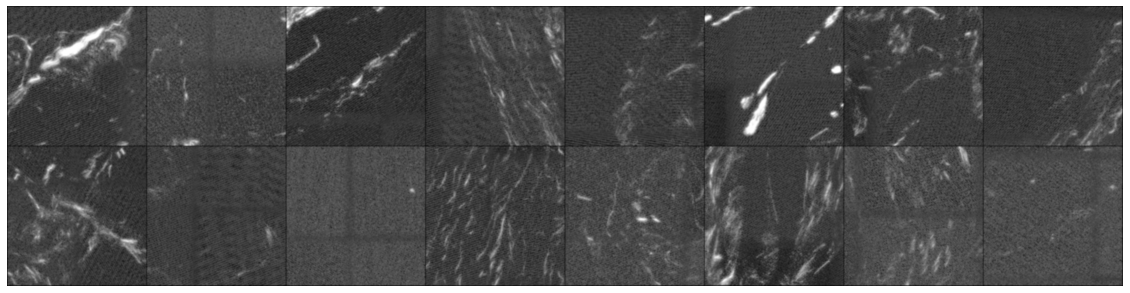

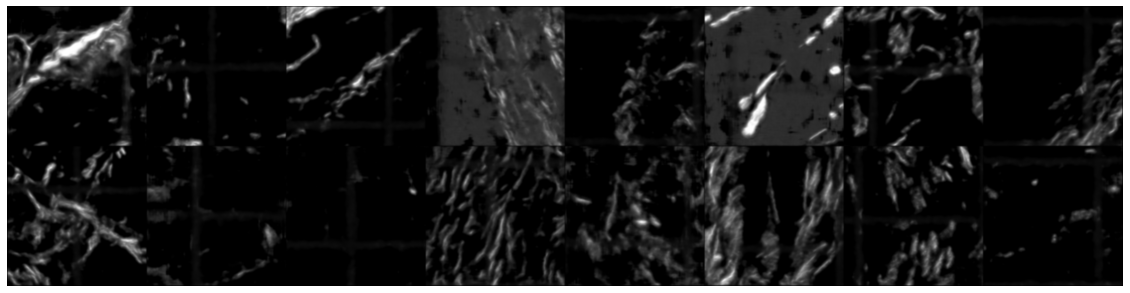

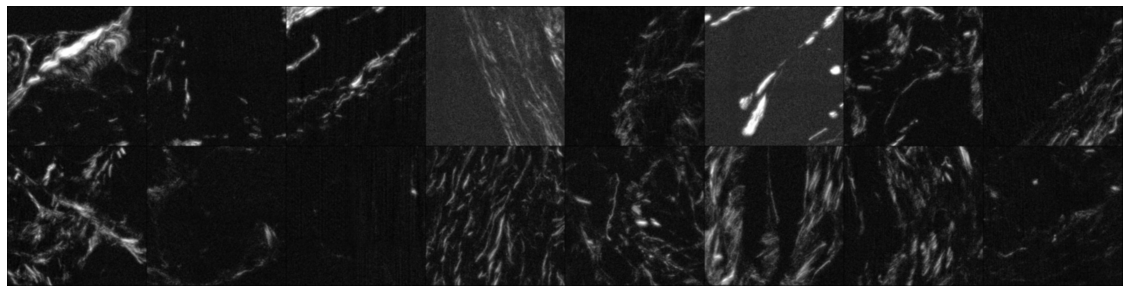

In [16]:
print_output(generator, valid_dataset)

===> 8x:


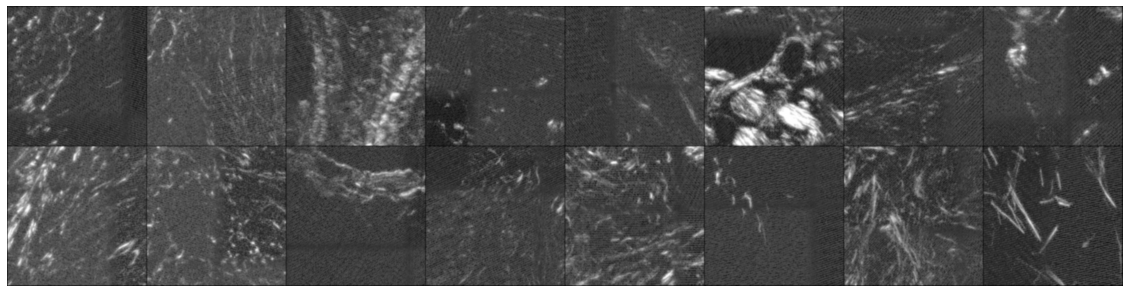

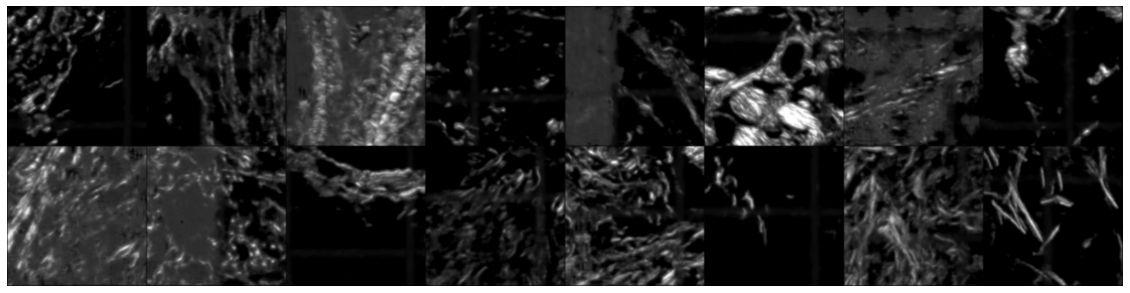

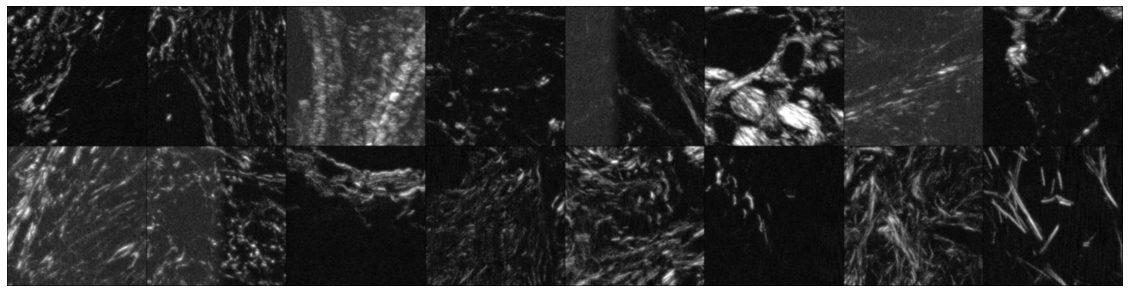

In [18]:
print_output(generator, train_dataset)